In [1]:
import pandas as pd
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split

In [2]:
classes = ["healthy", "early_blight", "late_blight", "bacterial_spot", "mosaic_virus"]

In [3]:
def create_dataset(dataset_dir, classes):
    image_array_list = []
    label_list = []

    image_list = []
    class_list = []

    dataset_dict = {
        "Image": image_list,
        "Class": class_list
    }

    for cls in classes:
        path = os.path.join(dataset_dir, cls)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (128, 128))
            img_normalized = img_resized / 255.0 # normalize

            image_array_list.append(img_normalized.flatten())
            label_list.append(classes.index(cls))

            image_list.append(img)
            class_list.append(cls)

    image_data = np.array(image_array_list)
    label_data = np.array(label_list)

    df = pd.DataFrame(image_data) 
    df["target"] = label_data

    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]

    dataset_df = pd.DataFrame(dataset_dict)

    return X, y, dataset_df, image_array_list

### PlantDoc

In [4]:
X_train, y_train, df_doc_train, img_doc_train = create_dataset("PlantDoc/train", classes)
X_test, y_test, df_doc_test, img_doc_test = create_dataset("PlantDoc/test", classes)

In [5]:
np.savez_compressed(
    "PlantDoc_v3.npz",
    X_train = X_train,
    X_test = X_test,
    y_train = y_train,
    y_test = y_test,
)

### PlantVillage

In [6]:
X, y, df_village, img_village = create_dataset("PlantVillage", classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
np.savez_compressed(
    "PlantVillage_v2.npz",
    X_train = X_train,
    X_test = X_test,
    y_train = y_train,
    y_test = y_test,
)

## EDA

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
def is_not_root(path):
    norm_path = os.path.normpath(path)
    parts = norm_path.split(os.sep)

    return len(parts) >= 2 and all(part.strip() != '' for part in parts[:2])

In [10]:
def collect_image_sizes(dataset_dir, classes):
    data = []
    
    for cls in classes:
        path = os.path.join(dataset_dir, cls)
        for img_file in os.listdir(path):
            img_path = os.path.join(path, img_file)
            img = cv2.imread(img_path)  
            if img is not None:  # Skip invalid/corrupted files
                height, width = img.shape[:2]  # Extract dimensions
                data.append({"width": width, "height": height, "class": cls})
            else:
                print(f"Invalid image: {img_path}")

    return pd.DataFrame(data)

In [11]:
def plot_image_sizes(df):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x="width", y="height", hue="class", alpha=0.8, s=80)
    plt.title("Image Sizes by Class (Width vs. Height)", fontsize=14)
    plt.xlabel("Width (pixels)", fontsize=12)
    plt.ylabel("Height (pixels)", fontsize=12)
    plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

In [12]:
def dataset_stat(df):
    print('Count the number of image datasets')
    print("Image Count : {}".format(len(df.Image)))
    print("Class Count : {} \n".format(len(df['Class'].value_counts())))
    print('Count the number of images in each class')
    print(df['Class'].value_counts())

In [13]:
def class_distribution(df):
    sns.countplot(data=df, x='Class')
    plt.title("Class Distribution")
    plt.xlabel("Class Index")
    plt.ylabel("Count")
    plt.show()

In [14]:
def plot_samples(dataset_dir, classes):
    plt.figure(figsize=(12, 6))
    
    for i, cls in enumerate(classes):
        path = os.path.join(dataset_dir, cls)
        sample_imgs = os.listdir(path)[:5]  # First 5 images
        
        for j, img_file in enumerate(sample_imgs):
            img = cv2.imread(os.path.join(path, img_file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            
            plt.subplot(5, 5, i*5 + j + 1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [15]:
def pixel_intensity(image_array_list):
    # Extract R, G, B channels from a sample image
    sample_img = image_array_list[0].reshape(128, 128, 3)
    channel_names = ['Red', 'Green', 'Blue']
    colors = ['red', 'green', 'blue']
    for i, (channel, color) in enumerate(zip(channel_names, colors)):
        plt.hist(sample_img[:, :, i].ravel(), bins=25, alpha=0.5, label=channel, color=color)
        
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel Value (0-1)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

In [16]:
def plot_color_histograms(dataset_dir, classes):
    plt.figure(figsize=(20, 15))
    
    for i, cls in enumerate(classes):
        path = os.path.join(dataset_dir, cls)
        img_file = os.listdir(path)[0]  # First image
        img = cv2.imread(os.path.join(path, img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        for ch, color in enumerate(['r', 'g', 'b']):
            plt.subplot(5, 3, i*3 + ch + 1)
            plt.hist(img[:, :, ch].ravel(), bins=25, color=color, alpha=0.7)
            plt.title(f"{cls} - {color.upper()} Channel")
            plt.xlabel("Pixel Intensity")
            plt.ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()

### PlantDoc

In [17]:
dataset_dir = "PlantDoc_"
df_doc = pd.concat([df_doc_train, df_doc_test], ignore_index=True)
img_doc = img_doc_train + img_doc_test

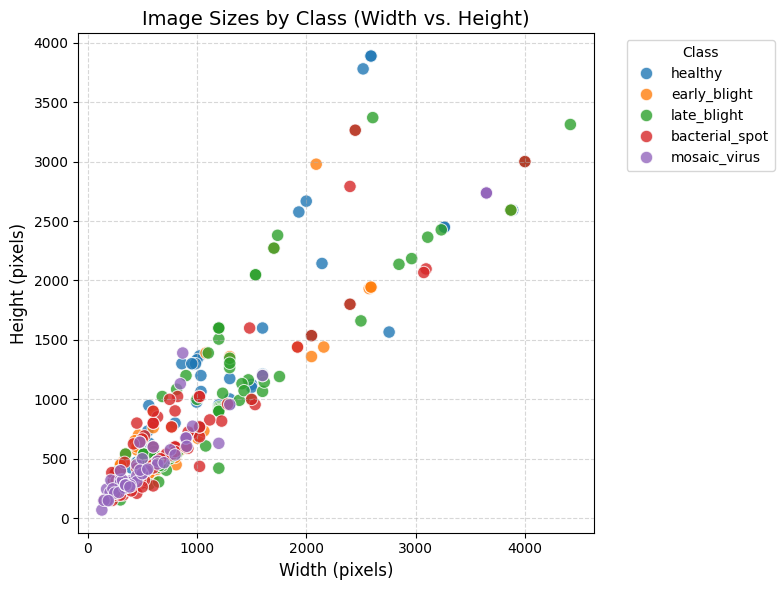

In [18]:
df_sizes = collect_image_sizes(dataset_dir, classes)
plot_image_sizes(df_sizes)

In [19]:
dataset_stat(df_doc)

Count the number of image datasets
Image Count : 426
Class Count : 5 

Count the number of images in each class
Class
late_blight       111
bacterial_spot    110
early_blight       88
healthy            63
mosaic_virus       54
Name: count, dtype: int64


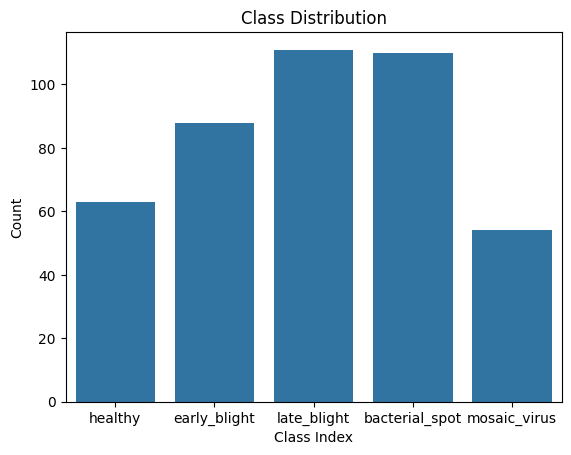

In [20]:
class_distribution(df_doc)

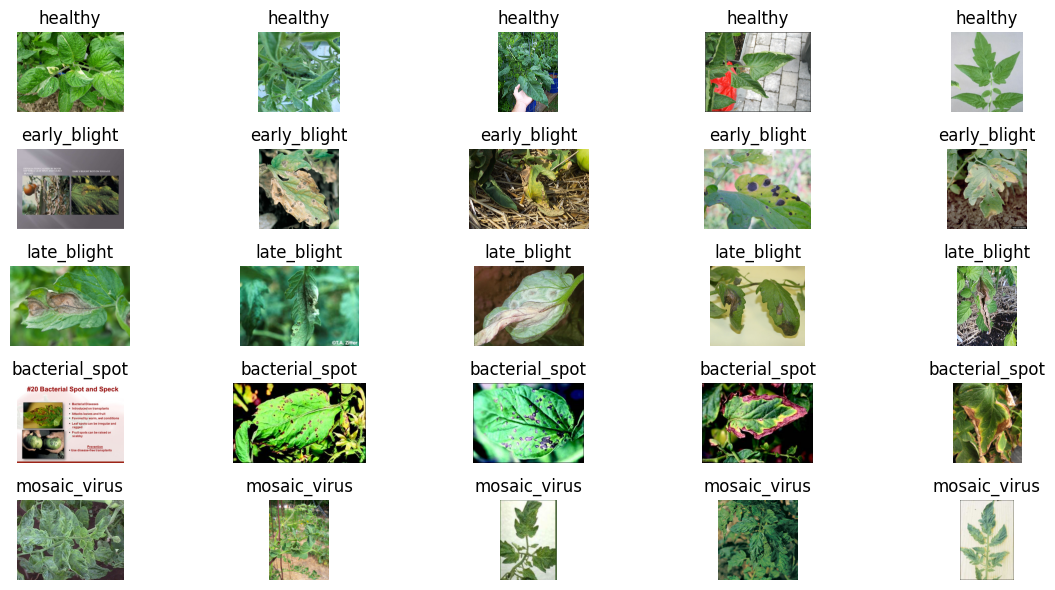

In [21]:
plot_samples(dataset_dir, classes)

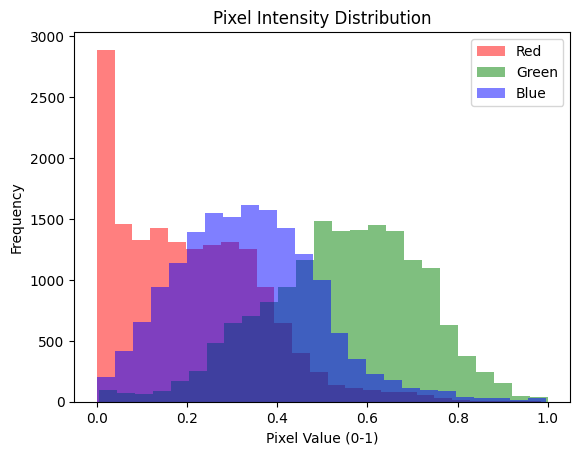

In [22]:
pixel_intensity(img_doc)

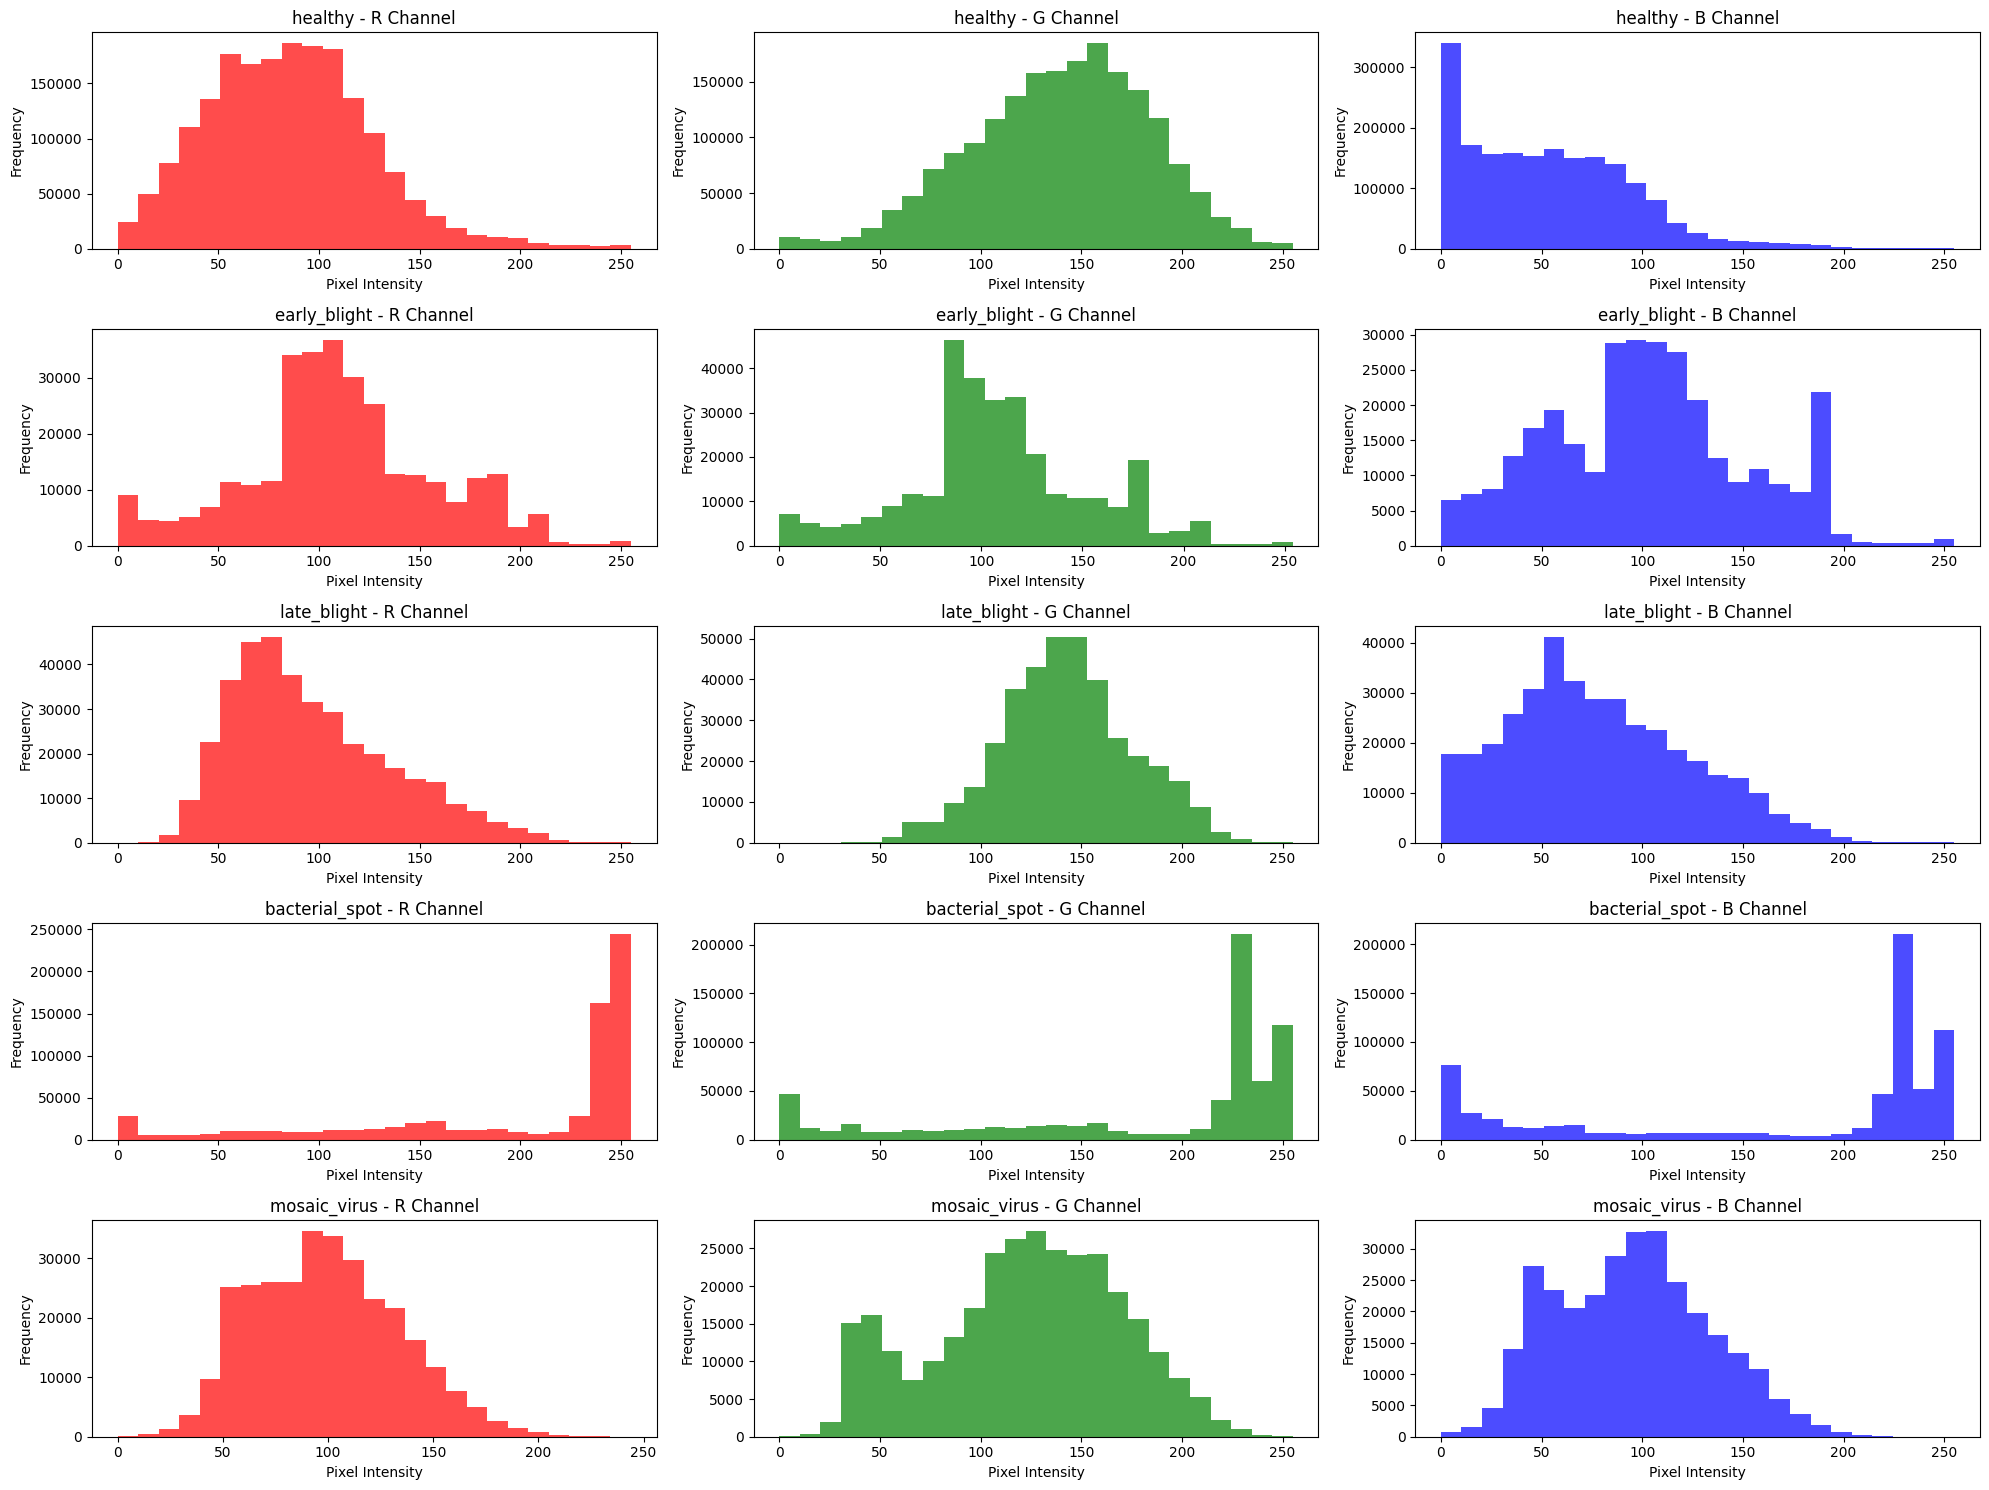

In [23]:
plot_color_histograms(dataset_dir, classes)

### PlantVillage

In [24]:
dataset_dir = "PlantVillage"

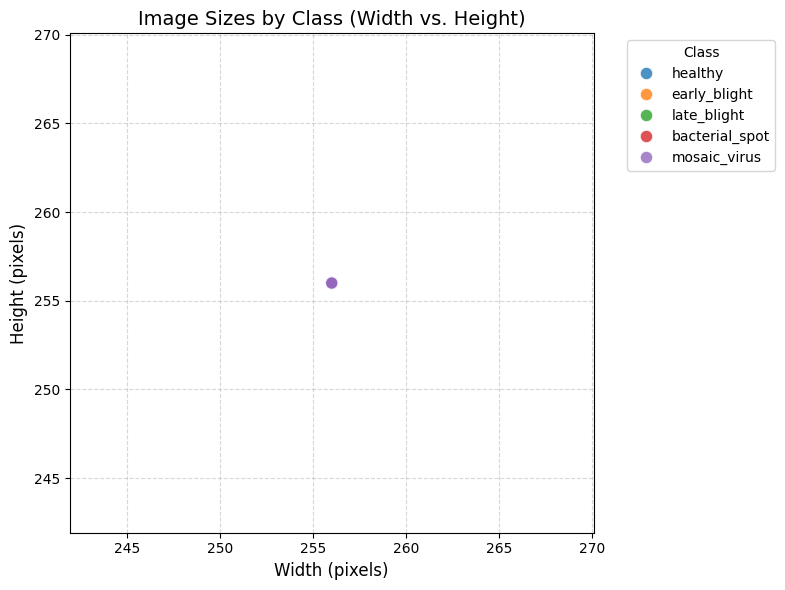

In [25]:
df_sizes = collect_image_sizes(dataset_dir, classes)
plot_image_sizes(df_sizes)

In [26]:
dataset_stat(df_village)

Count the number of image datasets
Image Count : 7000
Class Count : 5 

Count the number of images in each class
Class
bacterial_spot    2127
late_blight       1909
healthy           1591
early_blight      1000
mosaic_virus       373
Name: count, dtype: int64


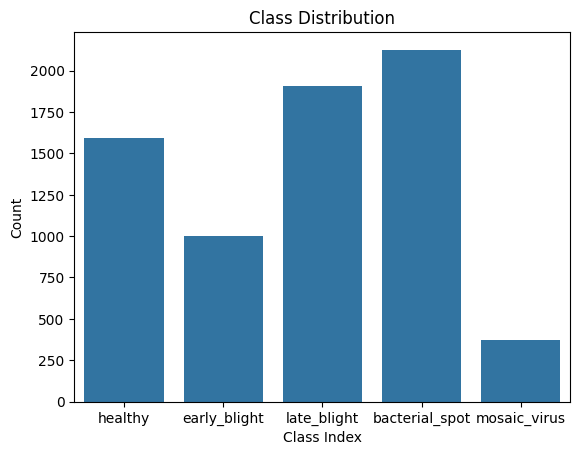

In [27]:
class_distribution(df_village)

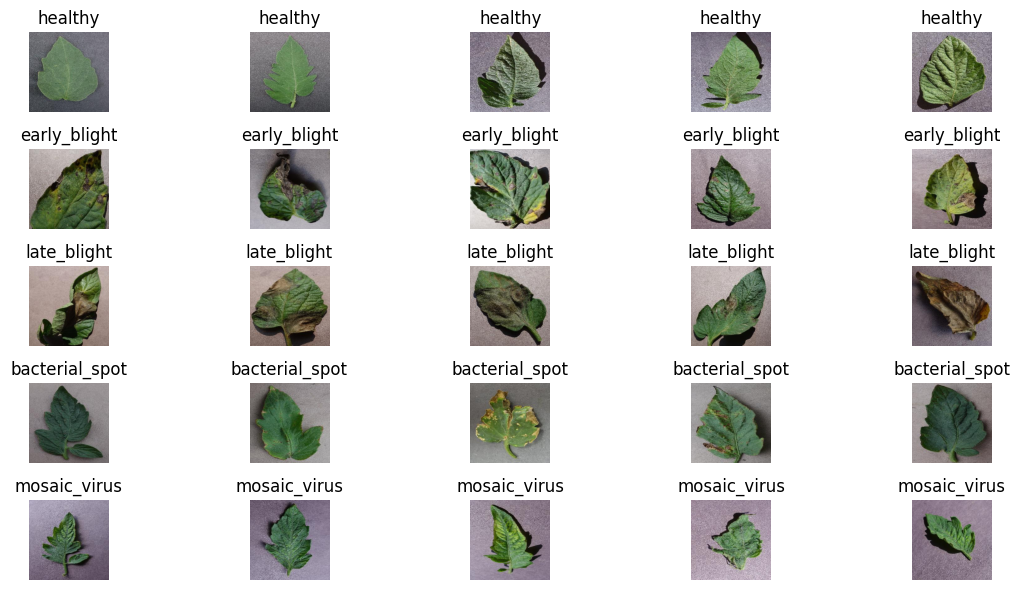

In [28]:
plot_samples(dataset_dir, classes)

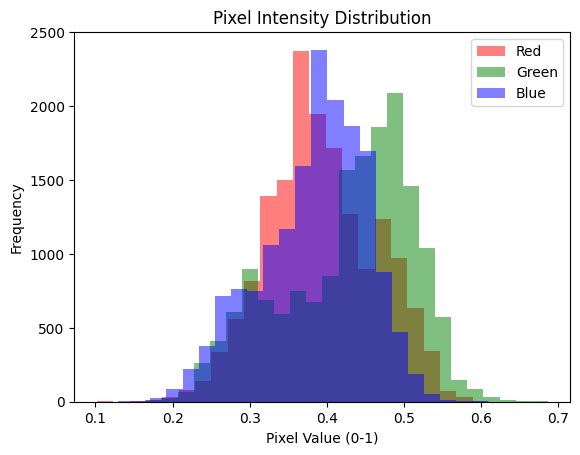

In [29]:
pixel_intensity(img_village)

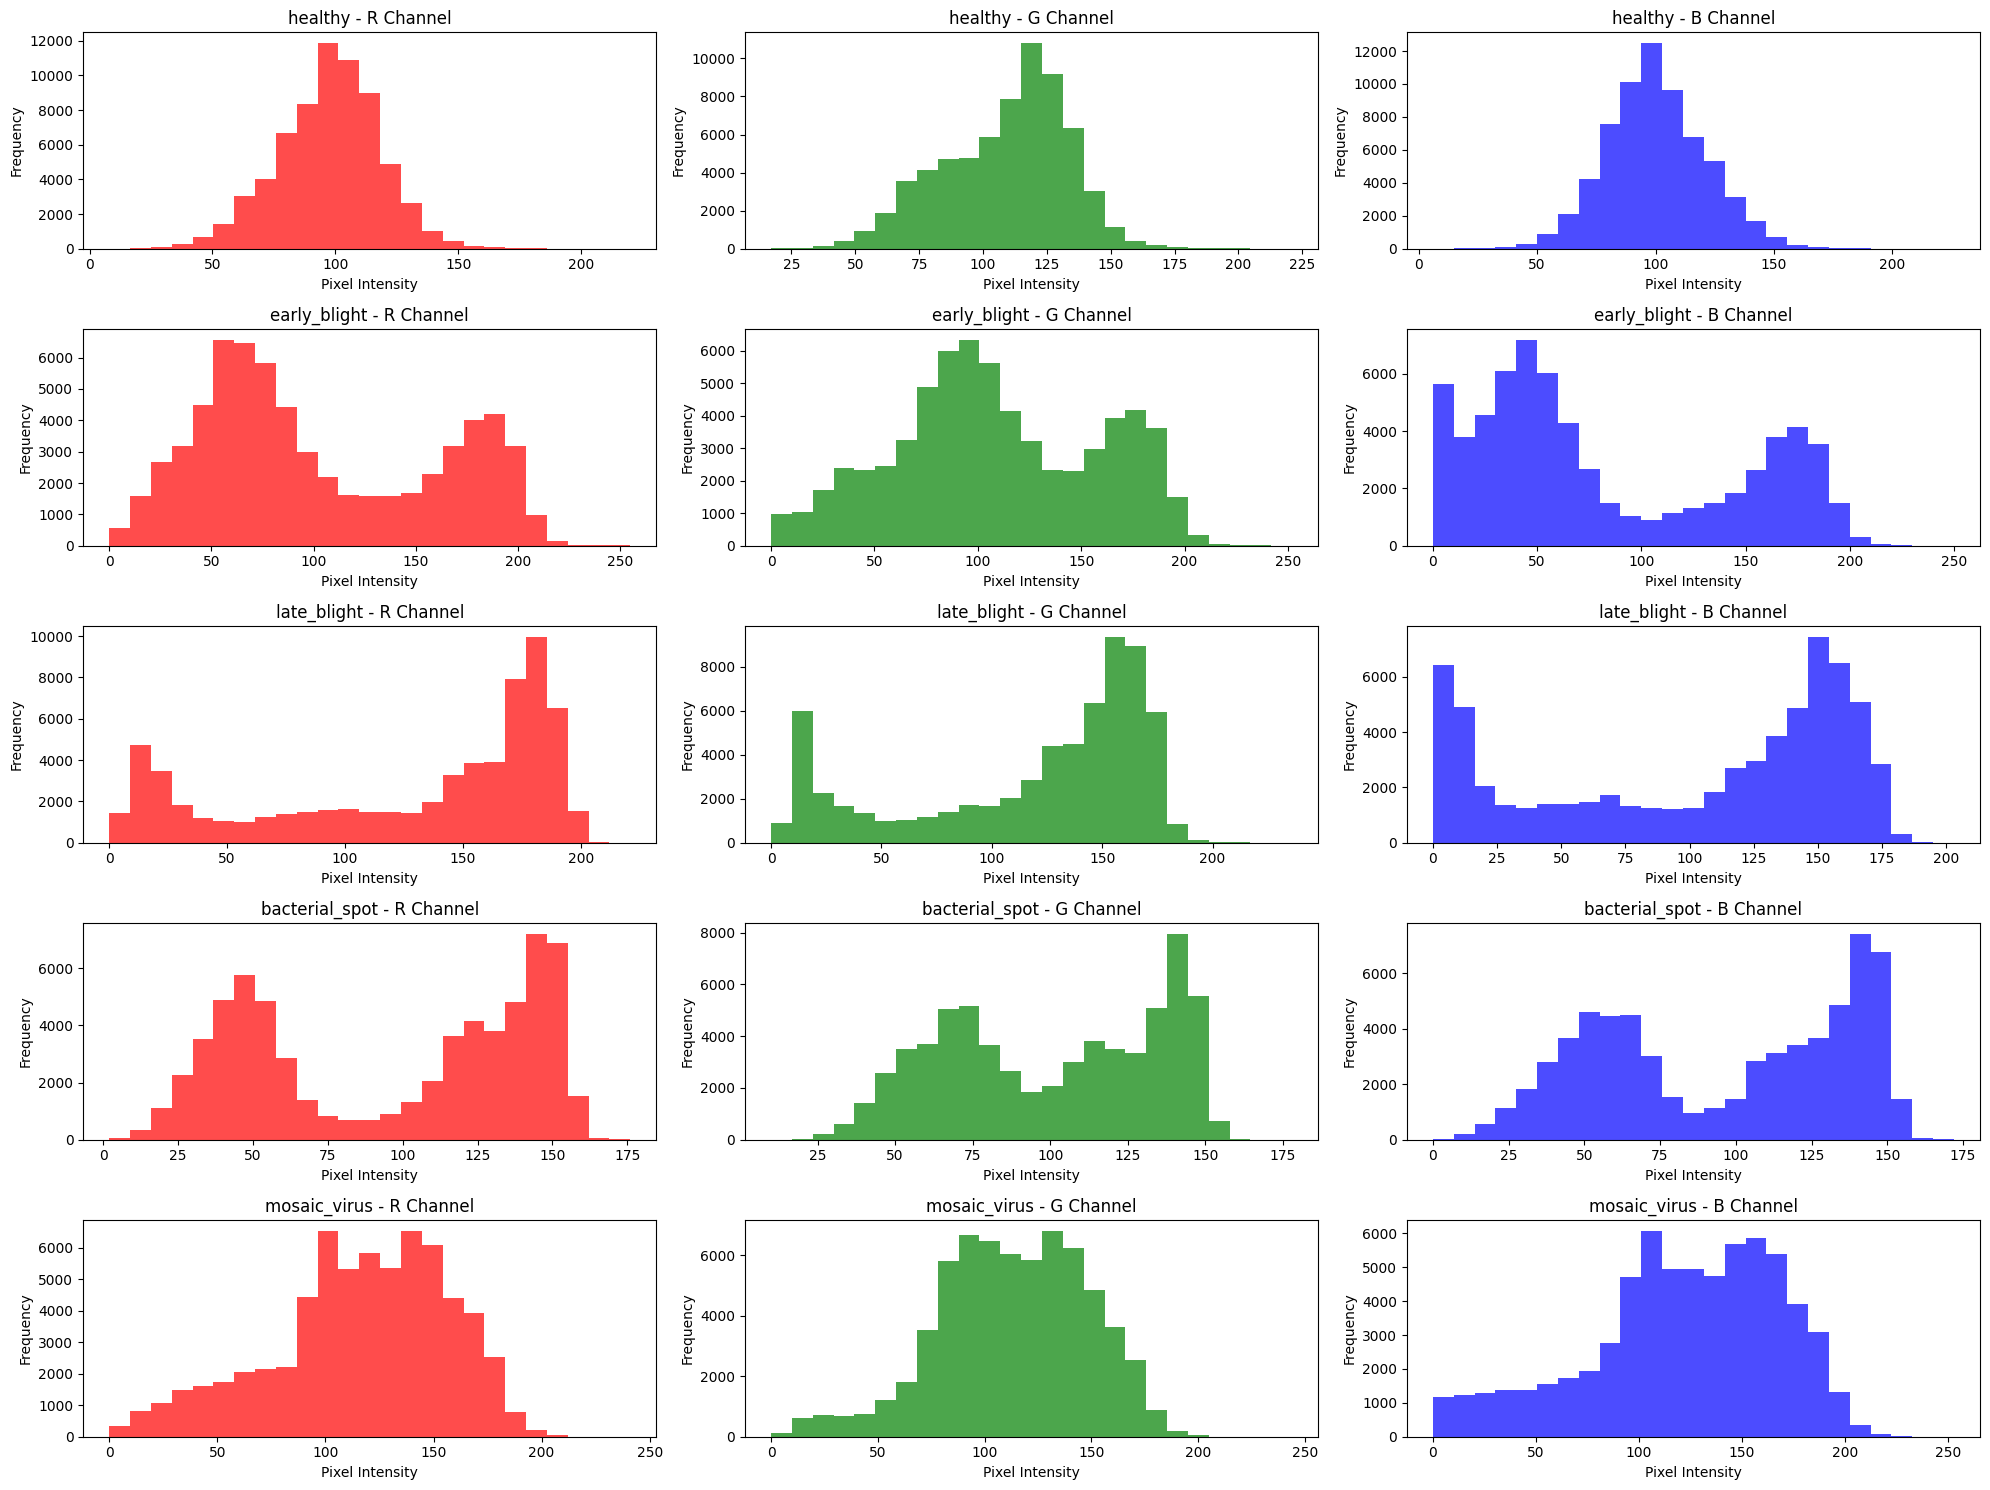

In [30]:
plot_color_histograms(dataset_dir, classes)